In [17]:
import torch
from torch_geometric.datasets import MoleculeNet
import torch.nn as nn
import torch_geometric.nn as geo_nn
from torch_geometric.loader import DataLoader, ImbalancedSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
dataset = MoleculeNet(root = "../../datasets", name = "HIV")
dataset.y = dataset.y.to(torch.int64)
label = dataset.y.numpy()
train_indices, test_indices = train_test_split(
    range(len(label)), test_size=0.2, stratify=label, random_state=42
)
# train_dataset = torch.utils.data.Subset(dataset, train_indices)
train_dataset = dataset[train_indices]

test_dataset = dataset[test_indices]
train_dataset.y = train_dataset.y[train_indices]
test_dataset.y = test_dataset.y[train_indices]
len(train_dataset.y)

32901

In [19]:
sampler = ImbalancedSampler(train_dataset)
dataloader = DataLoader(train_dataset, batch_size = 64, num_workers = 8, sampler = sampler)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset), num_workers = 8)

In [20]:
class GraphConvNet(nn.Module):
    class ConvBlock(nn.Module):
        def __init__(self, in_channel, out_channel) -> None:
            super().__init__()

            self.conv = geo_nn.GCNConv(in_channel, out_channel)
            self.relu = nn.ReLU()
        
        def forward(self, x, edge_list):
            hidden = self.conv(x, edge_list)
            return self.relu(hidden)

    def __init__(self, num_features, num_classes) -> None:
        super().__init__()
        self.num_channel = num_features
        self.conv1 = self.ConvBlock(self.num_channel, 16)
        self.conv2 = self.ConvBlock(16, 32)
        self.conv3 = self.ConvBlock(32, 64)
        self.conv4 = self.ConvBlock(64, 128)
        self.linear_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        self.out = nn.Sigmoid()

    def forward(self, x, edge_list, batch):
        hidden = self.conv1(x, edge_list)
        hidden = self.conv2(hidden, edge_list)
        # hidden = geo_nn.max_pool(hidden, batch)
        hidden = self.conv3(hidden, edge_list)
        hidden = self.conv4(hidden, edge_list)
        hidden = geo_nn.global_mean_pool(hidden, batch)
        return self.linear_layers(hidden)

In [21]:
from tqdm import tqdm
net = GraphConvNet(dataset.num_features, 2)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 2e-4, weight_decay=1e-6)
loss_fn = nn.CrossEntropyLoss()

num_epoch = 100

num_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_param}')
for i in tqdm(range(num_epoch)):
    net.train()
    total_loss = 0
    total_correct = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_x = batch.x.to(torch.float32).to(device)
        input_batch_edge_index = batch.edge_index.to(device)
        input_batch = batch.batch.to(device)
        batch_y = batch.y.squeeze().to(torch.int64).to(device)

        output = net(input_x, input_batch_edge_index, input_batch)
        loss = loss_fn(output, batch_y)
        total_loss += loss.item()
        total_correct += (batch_y == torch.argmax(output, dim = 1)).sum()
        loss.backward()
        optimizer.step()
    # print(f'Epoch {i}. Loss: {total_loss}. Accuracy: {total_correct/len(dataset)}')

    net.eval()
    labels = []
    prediction_probabilities = []
    for batch in test_dataloader:
        input_x = batch.x.to(torch.float32).to(device)
        input_batch_edge_index = batch.edge_index.to(device)
        input_batch = batch.batch.to(device)
        batch_y = batch.y.squeeze().to(torch.int64).to(device)
        output = net(input_x, input_batch_edge_index, input_batch)
        labels.extend(list(batch_y.detach().cpu().numpy()))
        prediction_probabilities.extend(list(torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()))
    
    fpr, tpr, _ = roc_curve(labels, prediction_probabilities)
    roc_auc = auc(fpr, tpr)
    print(f'Epoch {i}. Loss: {total_loss}. Train Accuracy: {total_correct/len(dataset)}. Test ROC: {roc_auc}')

Total number of parameters: 19522


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:10<16:51, 10.22s/it]

Epoch 0. Loss: 355.3912418484688. Train Accuracy: 0.427553653717041. Test ROC: 0.6137463145105073


  2%|▏         | 2/100 [00:19<16:07,  9.87s/it]

Epoch 1. Loss: 351.32795429229736. Train Accuracy: 0.44912099838256836. Test ROC: 0.6273587023763697


  3%|▎         | 3/100 [00:30<16:16, 10.07s/it]

Epoch 2. Loss: 348.0441424250603. Train Accuracy: 0.4594791531562805. Test ROC: 0.6445886791005117


  4%|▍         | 4/100 [00:40<16:10, 10.10s/it]

Epoch 3. Loss: 344.45211601257324. Train Accuracy: 0.47209861874580383. Test ROC: 0.6460683243867255


  4%|▍         | 4/100 [00:47<19:03, 11.91s/it]


KeyboardInterrupt: 

In [24]:
from torch_geometric.profile import count_parameters
num_param = count_parameters(net)
num_param

19522

In [ ]:
net.eval()
labels = []
prediction_probabilities = []
for batch in test_dataloader:
    input_x = batch.x.to(torch.float32).to(device)
    input_batch_edge_index = batch.edge_index.to(device)
    input_batch = batch.batch.to(device)
    batch_y = batch.y.squeeze().to(torch.int64).to(device)
    output = net(input_x, input_batch_edge_index, input_batch)
    labels.extend(list(batch_y.detach().cpu().numpy()))
    prediction_probabilities.extend(list(torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()))
print(len(labels))

8226


/home/ubuntu/miniconda3/envs/emthanhgraph/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


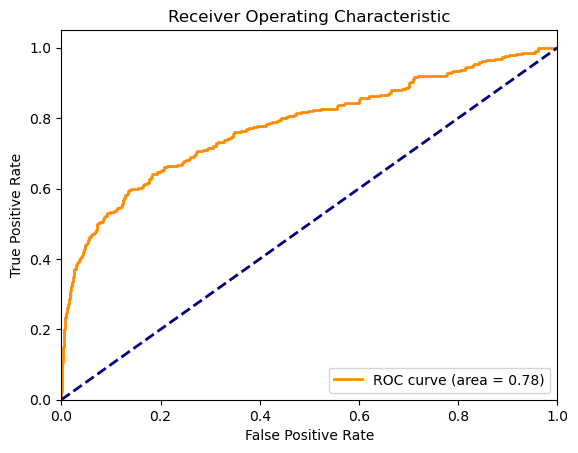

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(labels, prediction_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../../img/gcn_maxpool_100.png')
plt.show()
